# CARTE-Enbridge Bootcamp
#### Lab 4-1

# Analyzing Historical Safety Data

One valuable application of machine learning is in understanding historical safety data. In this workbook, we are going to take a look at historical data of road accidents in the UK. This data is available from the [UK government](https://data.gov.uk/dataset/road-accidents-safety-data). Understanding the factors that contribute to accidents can help us to make better decisions about how to improve safety.

We are going to use two new libraries to help us understand this data. The first is [ydata-profiling](https://github.com/ydataai/ydata-profiling), which is a library that helps us to understand the structure of our data. The second is [H2O](https://h2o.ai/), which is a library that allows us to easily test a wide range of models and configurations. Let's begin by installing the libraries.

In [1]:
# Check if we are in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# If we are in Colab, we need to install the ydata-profiling and H2O libraries
if IN_COLAB:
    !pip install -U -q ydata-profiling "typing-extensions<4.6.0" fastapi kaleido python-multipart uvicorn cohere openai tiktoken
    !pip install -U -q -f https://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [2]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from time import time
from pathlib import Path
import h2o
from h2o.automl import H2OAutoML

## Loading the Data

The first step is to load the data. We are going to use the `pandas` library to load the data from a CSV file. Because the data is quite large, once it's downloaded we will save it to a file so that we don't have to download it again.

In [3]:
if not Path('uk-road-traffic-accidents.csv').exists():
    print('Downloading data. This may take a few minutes.')
    incidents = pd.read_csv('https://github.com/alexwolson/carte_workshop_datasets/raw/main/uk-road-traffic-accidents.csv.zip', compression='zip', low_memory=False).fillna('No')
    incidents.to_csv('uk-road-traffic-accidents.csv',index=False)
else:
    incidents = pd.read_csv('uk-road-traffic-accidents.csv', low_memory=False).fillna('No')

## Understanding the Data

When we are looking at new data for the first time, it's important to get a good sense of what we're working with. The easiest thing to do is to take a look at a few rows of the data:

In [4]:
incidents.head()

,1st_Road_Class,1st_Road_Number,Accident_Severity,Carriageway_Hazards,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(Highway),...,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact
0,B,450.0,Slight,No,Wednesday,1.0,Auto traffic signal,Crossroads,Darkness - lights lit,Kensington and Chelsea,...,Heavy oil,Male,No,No tow/articulation,Did not leave carriageway,0.0,Slowing or stopping,Bus or coach (17 or more pass seats),No,Nearside
1,C,0.0,Slight,No,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,Darkness - lights lit,Kensington and Chelsea,...,Heavy oil,Male,No,No tow/articulation,Did not leave carriageway,0.0,Going ahead right-hand bend,Bus or coach (17 or more pass seats),No,Nearside
2,A,3220.0,Slight,No,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,Daylight,Kensington and Chelsea,...,Petrol,Female,No,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,Car,No,Front
3,Unclassified,0.0,Slight,No,Monday,1.0,Data missing or out of range,Not at junction or within 20 metres,Darkness - lighting unknown,Kensington and Chelsea,...,Petrol,Male,Skidded,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,Motorcycle 125cc and under,No,Front
4,Unclassified,0.0,Slight,No,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,Daylight,Kensington and Chelsea,...,Petrol,Male,No,No tow/articulation,Did not leave carriageway,0.0,Moving off,Car,No,Did not impact


But we can do better than that. The `ydata-profiling` library allows us to generate a report that gives us a lot of information about the data. `ydata-profiling` generates basic statistics about each column, including the number of missing values, the number of unique values, and the most common values. It also generates histograms for numeric columns and bar charts for categorical columns. Finally, it generates a correlation matrix that shows how each column is related to every other column. This is a great way to get a sense of the data.

The code below generates a report and saves it to an HTML file. If you're on Google Colab, you may need to download the HTML file to view it. Run the code below and have a look at the generated report.

**Your turn**

Look at the generated report.
- What is the most common day of the week for accidents? Friday
- What is the average speed limit for accidents? 40
- Is there anything unexpected that you notice? What is it? Accidents are most common at 5pm

Using a tool like `ydata-profiling` helps us to get a sense of what we're working with, quickly and easily. This is a great way to start any data science project. Note that this will take around 3 minutes on Google Colab.

In [5]:
if not Path('uk-road-traffic-accidents.html').exists():
    start_time = time()
    report = ProfileReport(incidents, title='UK Road Traffic Accidents')
    report.to_file('uk-road-traffic-accidents.html')
    print(f'Generated report in {(time() - start_time)/60:.2f} minutes')

## Building a Model

Now that we have a sense of what the data looks like, let's build a model to predict the severity of an accident. We are going to use the `H2O` library to conveniently test a range of machine learning models.

H2O has functionality called "AutoML" that allows us to automatically build a model. This is a great way to get started with machine learning. We will use the `H2OAutoML` class to build a model. This class will automatically try a number of different models and select the best one.

There are a couple of columns that we might want to predict in this dataset - `Accident_Severity` and `Number_of_Casualties`. To start with, we are going to make a model that predicts if an accident is fatal or not. We will use the `Accident_Severity` column as our target column. We will use all the other columns as our features. Because `Number_of_Casualties` is related to `Accident_Severity`, we will drop it from our features.

In [6]:
# Currently the time column is a string. We are going to convert it to a datetime column
incidents = incidents[incidents.Time != 'None']
incidents = incidents[incidents.Time != 'No']
incidents['Time'] = pd.to_datetime(incidents['Time'], format='%H:%M').copy()

In [7]:
# Because the data is so imbalanced, we are going to take 10,000 random samples from the non-fatal accidents and 10,000 random samples from the fatal accidents
# This will make the data more balanced, and make it easier to train a model
non_fatal = incidents[incidents['Accident_Severity'] == 'Slight'].sample(10000, random_state=42)
fatal = incidents[incidents['Accident_Severity'] == 'Fatal'].sample(10000, random_state=42)

# Combine the two samples into a single dataframe
incidents = pd.concat([non_fatal, fatal])

In [8]:
incidents['Accident_Severity'] = (incidents['Accident_Severity'] == 'Fatal')
print(incidents['Accident_Severity'].sum())

10000


In [9]:
x = incidents.columns
x = x.drop(['Accident_Severity', 'Number_of_Casualties','Did_Police_Officer_Attend_Scene_of_Accident'])
x = x.to_list()
y = 'Accident_Severity'
print(f'Features: {x}')
print(f'Target: {y}')

Features: ['1st_Road_Class', '1st_Road_Number', 'Carriageway_Hazards', 'Day_of_Week', 'Junction_Control', 'Junction_Detail', 'Light_Conditions', 'Local_Authority_(Highway)', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Junction_Location', 'make', 'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Location.Restricted_Lane', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact']
Target: Accident_Severity


As before, we will split our data into a training and testing set. We also need to convert our data into a format that H2O can understand. We will use the `h2o.H2OFrame` class to do this. This class is similar to a `pandas` dataframe, but it's designed to work with H2O. Lastly in this cell, will also convert our target column to a categorical column, because we want to predict a category.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    incidents[x],
    incidents[y],
    test_size=0.2,
    random_state=42
)

# Convert the data into a format that H2O can understand
h2o.init()
train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1)) # H2O expects a single dataframe with the features and target
test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

# Convert the target column to a categorical column
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Now we will define the settings for our model search. We have set the time for the search to run at 3 minutes.

In [11]:
# Define the settings for the model search
aml = H2OAutoML(
    project_name='UK_RTAs', # Give the model search a name
    sort_metric='AUCPR', # We want to maximize the area under the precision-recall curve - this is a good metric for imbalanced data
    max_runtime_secs=3*60, # Only allow the model search to run for 3 minutes
    seed=42, # Set the random seed for reproducibility
    verbosity='info', # Print out progress
    nfolds=0, # Don't use CV
    keep_cross_validation_predictions=True, # Save the cross-validation predictions - this will speed up the model search, but gives us worse understanding of model performance
    exclude_algos=['DeepLearning', 'StackedEnsemble'], # Don't use black-box models
    export_checkpoints_dir='checkpoints' # Save the models to a folder called "checkpoints"
)

Now we can train our model! This will take a few minutes. Note that you can see the progress of the model search in the output below.

In [ ]:
# Train the model
aml.train(
    x=x,
    y=y,
    training_frame=train,
    validation_frame=test
)

## Understanding the Model

Now that we have trained our model, we can take a look at the results. The `leaderboard` method will show us the best models found during the search. We can sort them by any of the different metrics calculated by H2O. We will sort by AUCPR, which is a good metric for imbalanced data.

In [ ]:
leaderboard = aml.leaderboard
leaderboard.head(rows=leaderboard.nrows)

We can retrieve the top performing model from the leaderboard based on AUCPR, but it's also possible to retrieve the best model based on other metrics, or the best model that uses a specific method:

In [14]:
# Get the best model
best_model = aml.leader

# Get the best model based on a specific metric
best_model_mpce = aml.get_best_model(criterion='mean_per_class_error')

# Get the best model that uses a specific method
best_model_xgb = aml.get_best_model(algorithm='GLM')

Let's look at the performance of our top model in a bit more detail. We can use scikit-learn's `confusion_matrix` function to see how many mistakes our model made, and calculate per-class accuracy:

In [15]:
from sklearn.metrics import confusion_matrix
y_pred = best_model.predict(test).as_data_frame()['predict'].values
cm = confusion_matrix(y_test, y_pred)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/home/alex/mambaforge/envs/enbridge_ydata/lib/python3.11/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'make' has levels not trained on: ["BMC", "BOMAG", "CCM", "DAVID BROWN", "GAS GAS", "JOHNSTON SWEEPERS", "LAMBRETTA", "LANDINI", "LIEBHERR", "LIGIER", "MAN/VW", "MEGELLI", "MORRIS", "PONTIAC", "SAME", "SD", "SKYJET", "VALMET", "WESTFIELD"]
  warnings.warn(w)
/home/alex/mambaforge/envs/enbridge_ydata/lib/python3.11/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'Special_Conditions_at_Site' has levels not trained on: ["Data missing or out of range"]
  warnings.warn(w)


In [16]:
print(f'Non-Fatal Accidents: {cm[0][0]} correct, {cm[0][1]} incorrect, {cm[0][0]/(cm[0][0]+cm[0][1])*100:.2f}% accuracy')
print(f'Fatal Accidents:     {cm[1][1]} correct, {cm[1][0]} incorrect, {cm[1][1]/(cm[1][1]+cm[1][0])*100:.2f}% accuracy')

Non-Fatal Accidents: 1383 correct, 636 incorrect, 68.50% accuracy
Fatal Accidents:     1734 correct, 247 incorrect, 87.53% accuracy


This is a good start, but we can dive deeper into understanding our model. H2O has a number of built-in functions that allow us to understand our model. The `varimp_plot` function will show us the most important features in our model:

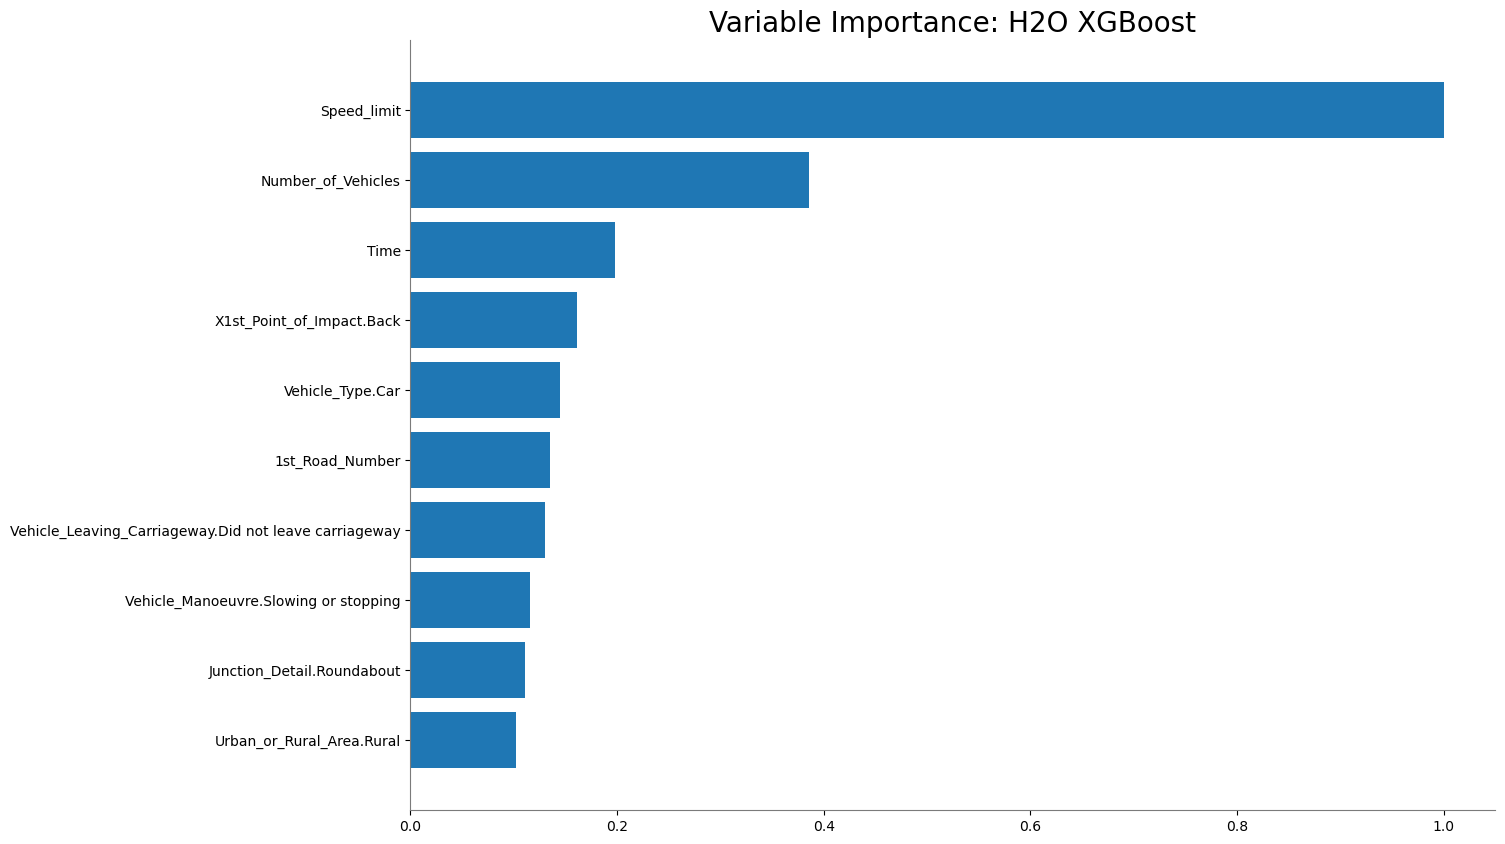

<Figure size 640x480 with 0 Axes>

In [17]:
best_model.varimp_plot();

This is a useful overview of which of our features impact the model the most. It's unsurprising that the speed limit is one of the most important features. But what about the other features? We can use the `partial_plot` function to see how each feature impacts the model. This function will show us how the model's predictions change as we change the value of a single feature. This is a great way to understand how the model works. Take a look at the plot for `Speed_limit`:

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


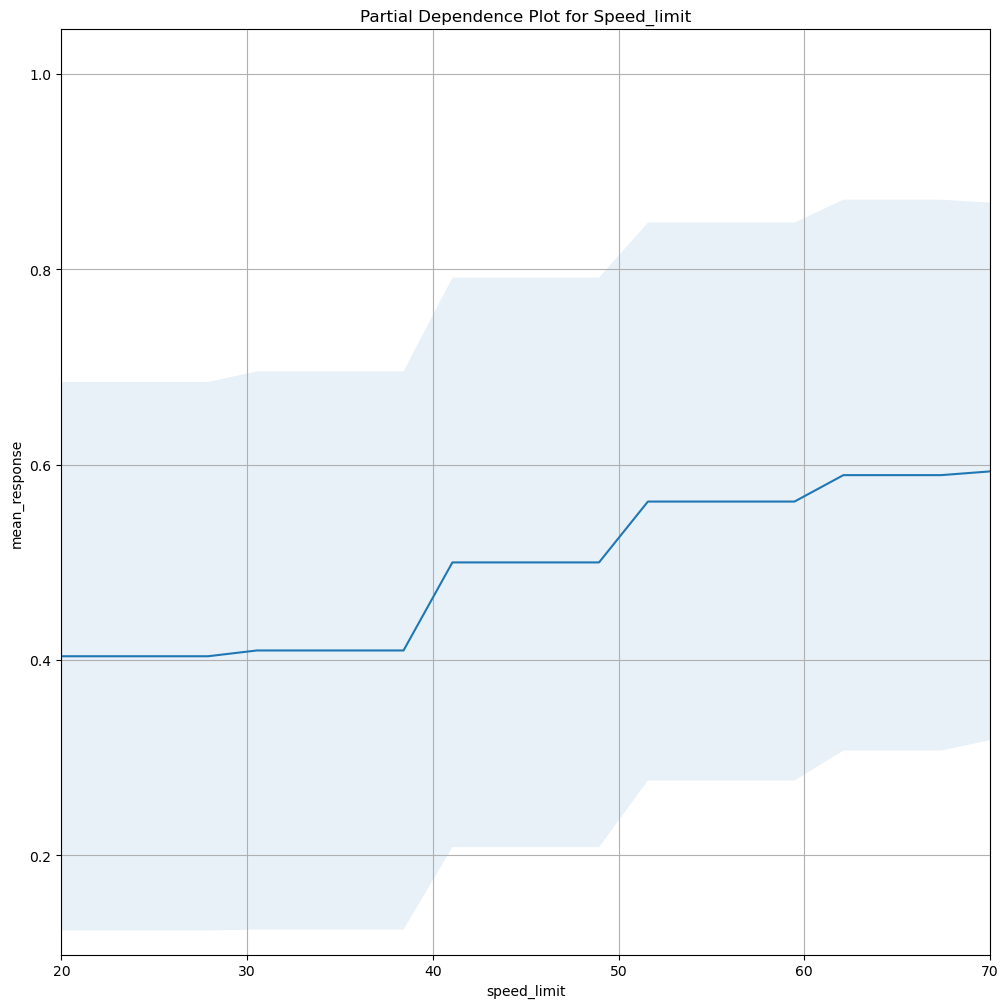

In [18]:
best_model.partial_plot(frame=test, cols=['Speed_limit'], figsize=(10,10));

This shows us in more detail how different speed limits affect the likelihood of our model predicting a fatality. It looks how we would expect.

**Your turn**

Choose another feature and look at its partial dependence plot. What do you notice? Sunday has the highest fatality prediction, despite Friday having the most accidents.

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


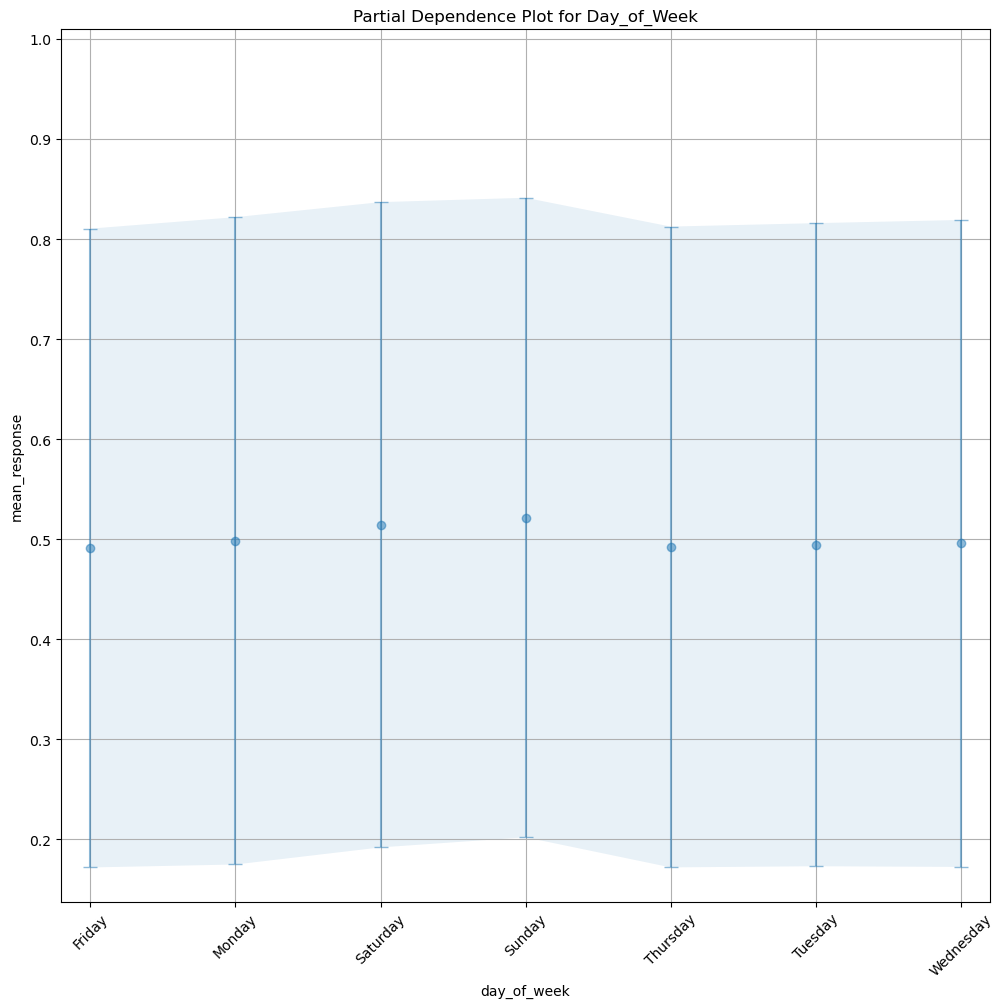

In [19]:
best_model.partial_plot(frame=test, cols=['Day_of_Week'], figsize=(10,10));

Finally, we can look at why the model made a specific prediction. First, we will look at the SHAP explanation for a specific row. SHAP is a method for explaining individual predictions. It shows us how each feature contributed to the model's prediction for a specific row. This is a great way to understand why the model made a specific prediction. Take a look at the SHAP explanation for the first row in the test set:

/home/alex/mambaforge/envs/enbridge_ydata/lib/python3.11/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'make' has levels not trained on: ["BMC", "BOMAG", "CCM", "DAVID BROWN", "GAS GAS", "JOHNSTON SWEEPERS", "LAMBRETTA", "LANDINI", "LIEBHERR", "LIGIER", "MAN/VW", "MEGELLI", "MORRIS", "PONTIAC", "SAME", "SD", "SKYJET", "VALMET", "WESTFIELD"]
  warnings.warn(w)
/home/alex/mambaforge/envs/enbridge_ydata/lib/python3.11/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'Special_Conditions_at_Site' has levels not trained on: ["Data missing or out of range"]
  warnings.warn(w)


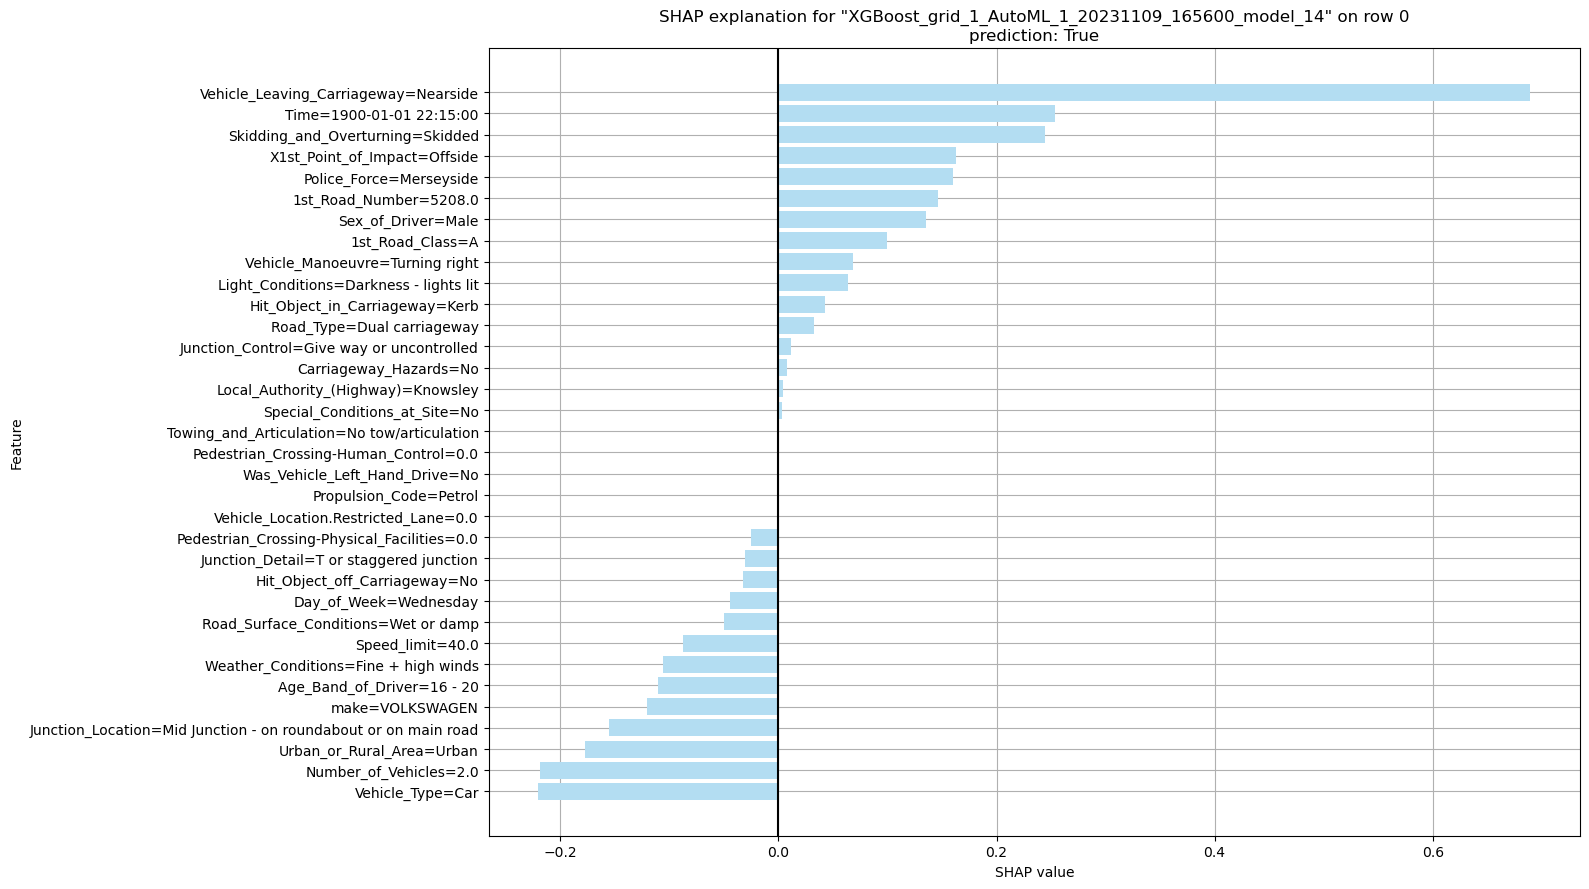

In [20]:
best_model.shap_explain_row_plot(test, row_index=0, top_n_features=20) # Show the contributions of the 20 most impactful values

From this, we can see that the most impactful value in terms of predicting a fatality in this specific case was that the vehicle left the carriageway (confusingly worded here as `Vehicle_Leaving_Carriageway.Did not leave carriageway=False`, which is a double negative). What if the car had been going slower? We can use the `pd_plot` function to see how the model's prediction would have changed if the car had been going slower:

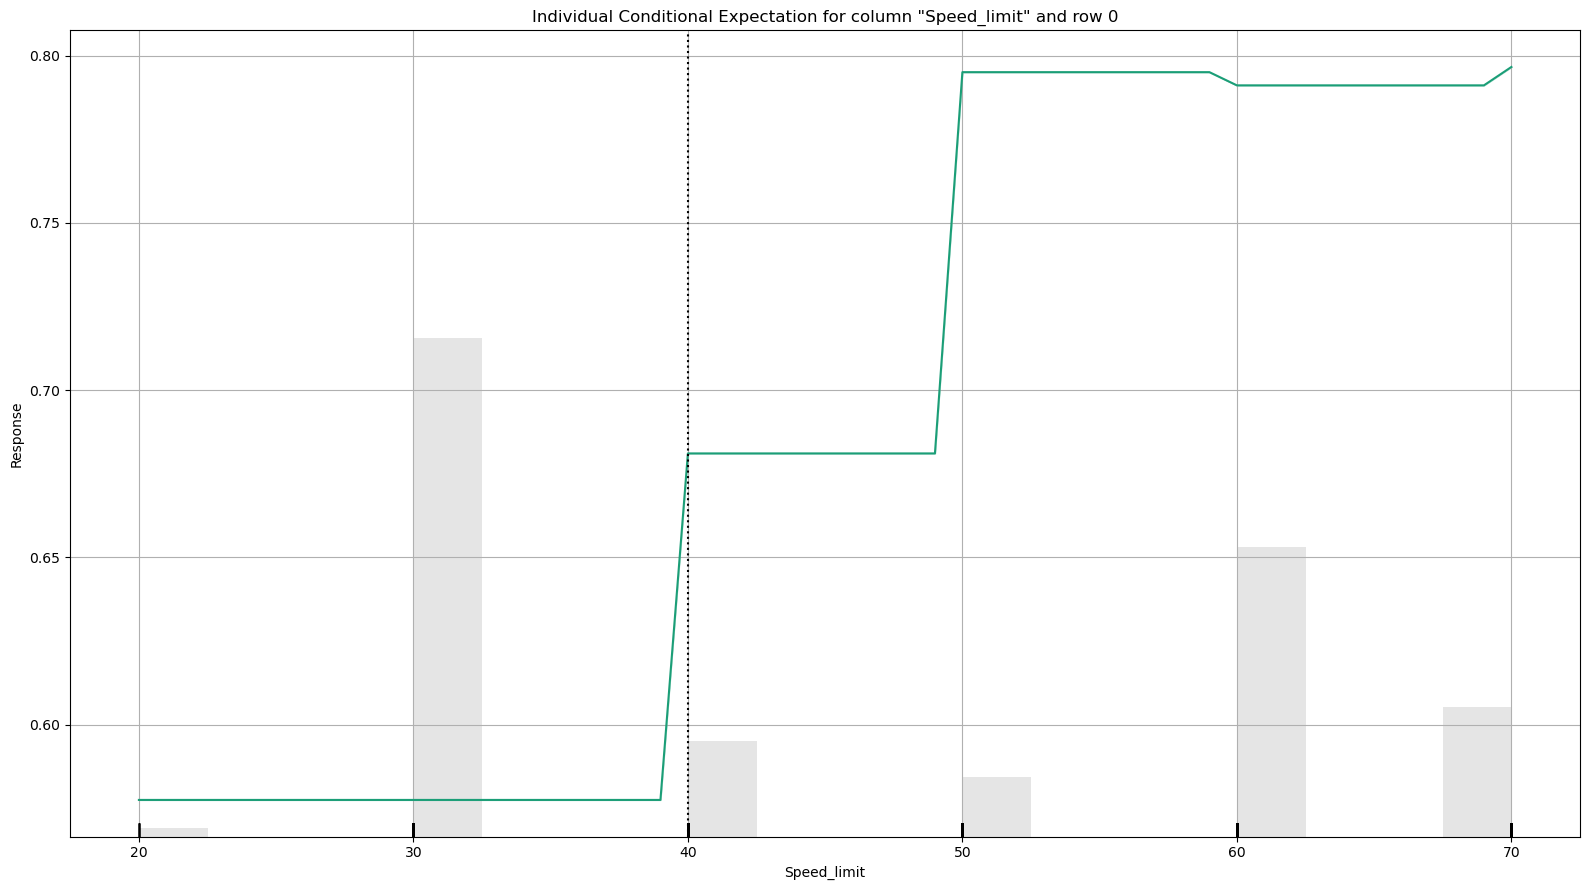

In [21]:
best_model.pd_plot(test, 'Speed_limit', row_index=0)

This shows us that if the car had been going slower, the model would have been less likely to predict a fatality. This is a great way to understand how the model works.

## Conclusion

In this workbook, we have looked at how to use machine learning to understand historical safety data. We have used the `ydata-profiling` library to understand the data, and the `H2O` library to build an explainable machine learning model. We have seen how to use the `H2OAutoML` class to automatically build a model, and how to use the `varimp_plot`, `partial_plot`, and `shap_explain_row_plot` functions to understand the model. We have seen how to use the `pd_plot` function to understand how the model's predictions would have changed if the data had been different.